## Importing Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the dataset

In [ ]:
dataset = pd.read_csv("data/CO2 Emissions_Canada.csv")

## Data cleaning and engeenering

In [35]:
non_informative_columns = ["Make", "Model"]
redundant_columns = ["Fuel Consumption Comb (L/100 km)", "Fuel Consumption Comb (mpg)"]
# The producer can't know fuel consumption in advance.
# It can only be mesured after the car is built.
# Since the variable is useless for prediction, it shouldn't be used for training.
leakage_variables = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)"]
columns_to_drop = non_informative_columns + redundant_columns + leakage_variables
dataset.drop(columns=columns_to_drop, inplace=True)
dataset.isna().sum()

Vehicle Class          0
Engine Size(L)         0
Cylinders              0
Transmission           0
Fuel Type              0
CO2 Emissions(g/km)    0
dtype: int64

## Features and Target division

In [36]:
y = dataset["CO2 Emissions(g/km)"]
X = dataset.drop("CO2 Emissions(g/km)", axis=1)

## Splitting the data into Train and Test sets

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

## Trying different models

### Preparing column transformers for different types of models

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

categorical_cols = ["Vehicle Class", "Transmission", "Fuel Type"]
numeric_cols = X.columns.difference(categorical_cols)
ohe_transformer = ("encoder", OneHotEncoder(handle_unknown='ignore', drop=None), categorical_cols) # drop=None, since unseen classes might meet in the test set.
sc_transformer = ('scaler', StandardScaler(), numeric_cols)
oe_transformer = (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_cols,
)

ct_linear_and_mlp = ColumnTransformer(
    transformers=[ohe_transformer, sc_transformer], remainder="passthrough"
)

ct_tree = ColumnTransformer(
    transformers=[
        oe_transformer
    ],
    remainder="passthrough"
)

### Tweeking the grid search parameters

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

pipeline = Pipeline(
    [
        ("preprocessing", "passthrough"),
        ("poly", "passthrough"),
        ("regressor", DummyRegressor()),
    ]
)

param_grid = [
    {
        "preprocessing": [ct_linear_and_mlp],
        "poly": [
            PolynomialFeatures(degree=1, include_bias=False),
            PolynomialFeatures(degree=2, include_bias=False),
        ],
        "regressor": [LinearRegression()],
    },
    {
        "preprocessing": [ct_linear_and_mlp],
        "poly": ["passthrough"],
        "regressor": [SVR()],
    },
    {
        "preprocessing": [ct_tree],
        "poly": ["passthrough"],
        "regressor": [
            DecisionTreeRegressor(random_state=23),
            RandomForestRegressor(random_state=23),
            GradientBoostingRegressor(random_state=23),
        ],
    },
    {
        "preprocessing": [ct_linear_and_mlp],
        "poly": ["passthrough"],
        "regressor": [MLPRegressor(max_iter=1000, random_state=42, early_stopping=True)],
        "regressor__hidden_layer_sizes": [
            (100,),
            (100, 100),
            (110, 110),
            (90, 90),
            (120, 120),
        ],
        "regressor__activation": [
            "relu",
            "tanh"
            ],
        "regressor__alpha": [0.0001, 0.001],
    },
]

scoring = {
    "r2": "r2",
    "rmse": "neg_root_mean_squared_error",
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=scoring,
    refit="r2",   # the best model will be chosen by R², even though RMSE will also be calculated
    n_jobs=-1,
    verbose=1,
)

### Training the models

In [40]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('poly', 'passthrough'),
                                       ('regressor', DummyRegressor())]),
             n_jobs=-1,
             param_grid=[{'poly': [PolynomialFeatures(degree=1,
                                                      include_bias=False),
                                   PolynomialFeatures(include_bias=False)],
                          'preprocessing': [ColumnTransformer(remainder='passthrough',
                                                              transformers=[('encoder',
                                                                             OneHotEncoder(h...
                                                                             Index(['Cylinders', 'Engine Size(L)'], dtype='object'))])],
                          'regressor': [MLPRegressor(early_stopping=True,
                                                     max_iter=1000,
                                                     random_state=42)],
                          'regressor__activation': ['relu', 'tanh'],
                          'regressor__alpha': [0.0001, 0.001],
                          'regressor__hidden_layer_sizes': [(100,), (100, 100),
                                                            (110, 110),
                                                            (90, 90),
                                                            (120, 120)]}],
             refit='r2',
             scoring={'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'},
             verbose=1)

## Models comparison

### Evaluating the models by $ \mathbb{R}^ 2 $ and RMSE scores

In [41]:
results = grid.cv_results_
r2_scores   = results["mean_test_r2"]
rmse_scores = -results["mean_test_rmse"]
params = results["params"]

# Build readable labels for specific models, to including hyperparameters to labels
model_labels = []
for p in params:
    model = type(p["regressor"]).__name__
    label_parts = [model]

    if "regressor__kernel" in p:
        label_parts.append(f"kernel={p['regressor__kernel']}")
    if "regressor__hidden_layer_sizes" in p:
        label_parts.append(f"layers={p['regressor__hidden_layer_sizes']}")
    if "regressor__activation" in p:
        label_parts.append(f"act={p['regressor__activation']}")
    if "poly__degree" in p:
        label_parts.append(f"poly={p['poly__degree']}")
    if "regressor__max_depth" in p and p["regressor__max_depth"] is not None:
        label_parts.append(f"depth={p['regressor__max_depth']}")

    model_labels.append(" | ".join(label_parts))

model_labels = np.array(model_labels)

### Cross-validation $ \mathbb{R}^ 2 $ barh plot

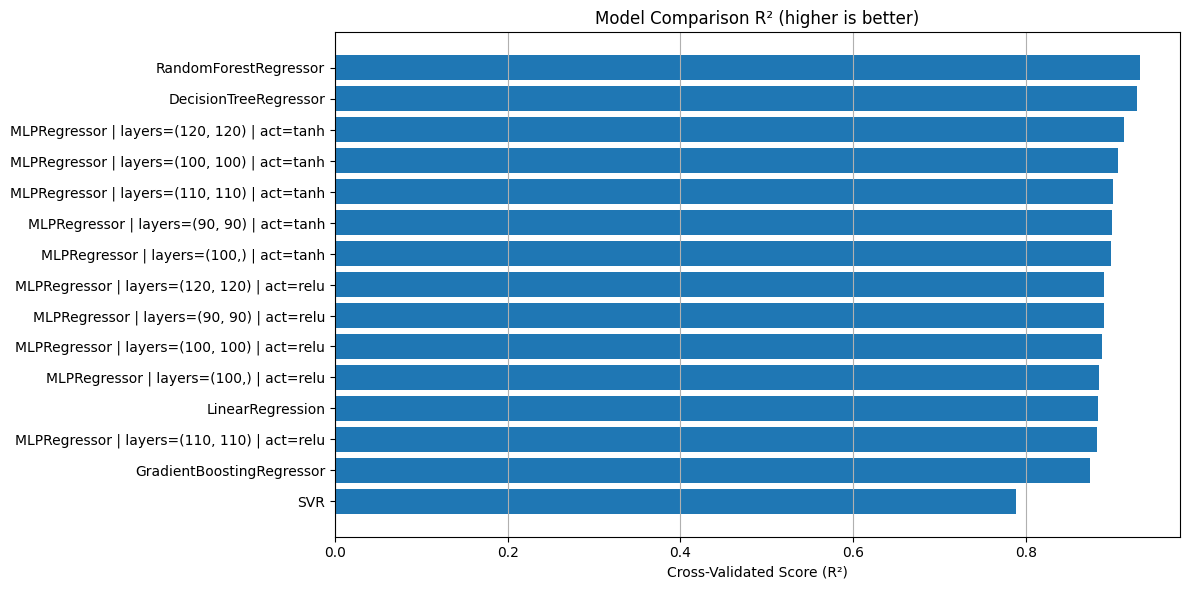

In [42]:
r2_sorted_idx    = np.argsort(r2_scores)[::-1]
r2_sorted_scores = r2_scores[r2_sorted_idx]
r2_sorted_labels = model_labels[r2_sorted_idx]

plt.figure(figsize=(12, 6))
plt.barh(r2_sorted_labels, r2_sorted_scores)
plt.xlabel("Cross-Validated Score (R²)")
plt.title("Model Comparison R² (higher is better)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis="x")
plt.show()

### Cross-validation RMSE barh plot

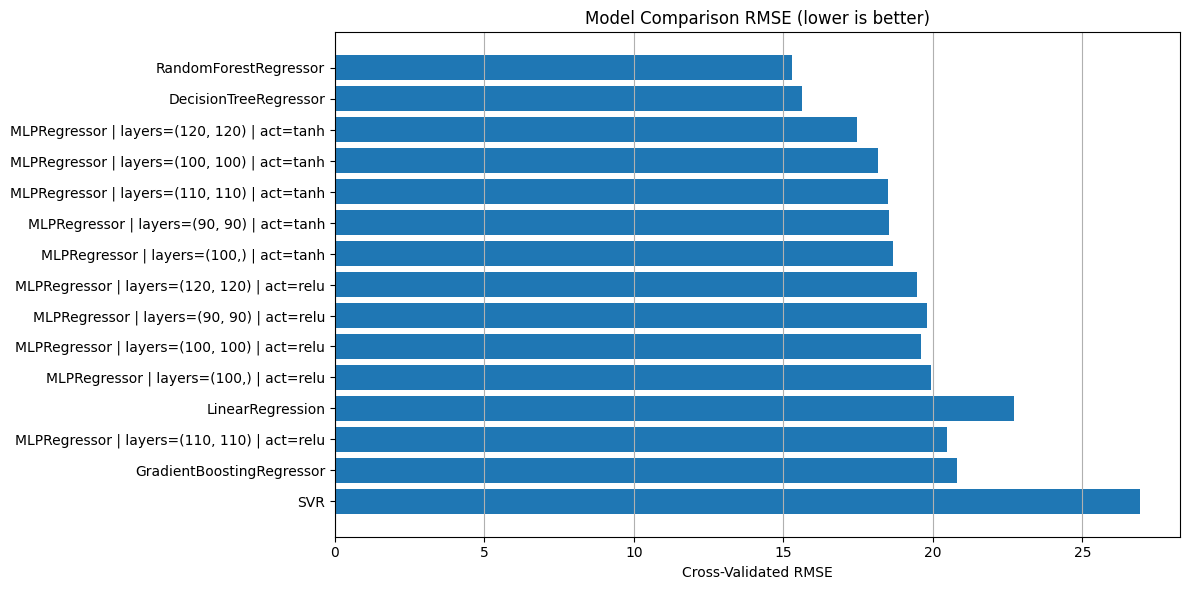

In [43]:
rmse_sorted_idx    = np.argsort(rmse_scores)
rmse_sorted_scores = rmse_scores[rmse_sorted_idx]
rmse_sorted_labels = model_labels[rmse_sorted_idx]

plt.figure(figsize=(12, 6))
plt.barh(rmse_sorted_labels, rmse_sorted_scores)
plt.xlabel("Cross-Validated RMSE")
plt.title("Model Comparison RMSE (lower is better)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis="x")
plt.show()

### Selecting the best One

In [44]:
best_pipeline = grid.best_estimator_
best_model = best_pipeline.named_steps['regressor']
model_name = type(best_model).__name__

print(model_name)

hyperparams = ""
is_poly = 'poly' in best_pipeline.named_steps
if is_poly:
    poly_step = best_pipeline.named_steps['poly']
    if hasattr(poly_step, 'degree'):
        hyperparams = f"(poly_degree={poly_step.degree})"


print(
    f"The top-performing model is {model_name}{hyperparams if is_poly else ''}\n"
    f"with an accuracy (cross-validated R^2 score) of {grid.best_score_:.4f}."
)

RandomForestRegressor
The top-performing model is RandomForestRegressor
with an accuracy (cross-validated R^2 score) of 0.9315.


### Evaluation of the top 3 models by CV metrics on the test set to ensure in accuracy

In [49]:
from sklearn.base import clone

results = grid.cv_results_

cv_r2  = results["mean_test_r2"]
cv_rmse = -results["mean_test_rmse"]

top_k = 3
top_idx = np.argsort(cv_r2)[::-1][:top_k]

print("Top 3 models (by CV R²):\n")

for rank, idx in enumerate(top_idx, start=1):
    params = results["params"][idx]

    # Rebuild the pipeline with the same hyperparameters
    model_i = clone(grid.estimator)
    model_i.set_params(**params)
    model_i.fit(X_train, y_train)

    y_pred_test_i = model_i.predict(X_test)

    test_r2_i = r2_score(y_test, y_pred_test_i)
    test_rmse_i = root_mean_squared_error(y_test, y_pred_test_i)

    reg_name = type(model_i.named_steps["regressor"]).__name__

    print(f"Model #{rank}: {reg_name}")
    print(f"  CV R²   : {cv_r2[idx]:.4f}")
    print(f"  CV RMSE : {cv_rmse[idx]:.4f}")
    print(f"  Test R² : {test_r2_i:.4f}")
    print(f"  Test RMSE: {test_rmse_i:.4f}")
    print("-" * 50)

Top 3 models (by CV R²):

Model #1: RandomForestRegressor
  CV R²   : 0.9315
  CV RMSE : 15.2981
  Test R² : 0.9317
  Test RMSE: 15.2641
--------------------------------------------------
Model #2: DecisionTreeRegressor
  CV R²   : 0.9285
  CV RMSE : 15.6364
  Test R² : 0.9223
  Test RMSE: 16.2768
--------------------------------------------------
Model #3: MLPRegressor
  CV R²   : 0.9129
  CV RMSE : 17.2554
  Test R² : 0.9101
  Test RMSE: 17.5101
--------------------------------------------------


## 👨‍⚖️ Final verdict:
### After evaluation on the test set - RandomForestRegressor is still the best model, based on both $ \mathbb{R}^ 2 $ and RMSE scores.

## Model inference for a Single Instance

In [46]:
vehicle_prototype_instance = pd.DataFrame([{
'Vehicle Class': "COMPACT",
'Engine Size(L)': 2,
'Cylinders': 4,
'Transmission': "AS5",
'Fuel Type': "Z",
}])

In [47]:
co2_emission_pred = grid.predict(vehicle_prototype_instance)[0]

In [48]:
print(f"For a vehicle with characteristics:")
for key, val in vehicle_prototype_instance.items():
    print(f"{key}: {val.iloc[0]}")
print(f"The predicted emissions of CO2 are: {co2_emission_pred:.2f} g/km")

For a vehicle with characteristics:
Vehicle Class: COMPACT
Engine Size(L): 2
Cylinders: 4
Transmission: AS5
Fuel Type: Z
The predicted emissions of CO2 are: 201.59 g/km
